In [1]:
import pandas as pd
import numpy as np
from PIL import Image
from PIL import ImageOps
import PIL
import torch, torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from dataset import defectDataset_convolution
import random
import math
import seaborn
from  matplotlib import pyplot
import torch.nn.functional as F
import matplotlib.image as mpimg
import torch.nn as nn
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float

In [17]:
step_size = 2
window_size = 45
batch_size = 512
num_workers = 4
output_path = '/home/rliu/defect_classifier/convolution_test/'
df_yolo = pd.read_csv('/home/rliu/github/defect_classifier/yolo2_dm/results/test_yolo.csv', sep=' ')
df_test = pd.read_csv('/home/rliu/yolo2/v2_pytorch_yolo2/data/an_data/VOCdevkit/VOC2007/csv_labels/test.csv', sep=" ")

In [18]:
df_test.image_index.unique().shape

(1699,)

In [4]:
def create_circular_mask(h, w, center=None, radius=None):
    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    mask = mask.astype(int)
    return mask

mask = create_circular_mask(200,200)

In [5]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()                    # Inherited from the parent class nn.Module
        self.fc1 = nn.Linear(input_size, hidden_size)  # 1st Full-Connected Layer: 10 (input data) -> 500 (hidden node)
        self.relu = nn.ReLU()                          # Non-Linear ReLU Layer: max(0,x)
        self.fc2 = nn.Linear(hidden_size, num_classes) # 2nd Full-Connected Layer: 500 (hidden node) -> 5 (output class)
#         self.relu = nn.ReLU()                          # Non-Linear ReLU Layer: max(0,x)
#         self.fc3 = nn.Linear(hidden_size, num_classes) # 3rd Full-Connected Layer: 500 (hidden node) -> 5 (output class)
    
    def forward(self, x):                              # Forward pass: stacking each layer together
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
#         out = self.relu(out)
#         out = self.fc3(out)
        return out

In [6]:
data_transform = transforms.Compose([
        transforms.RandomResizedCrop(200, scale=(1, 1), ratio=(1, 1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.3019],
                             std=[0.1909])
    ])

In [16]:
classes = ["pos","neg","pos_o","nuc","non"]
num_of_classes = len(classes)
model_uniform = torch.load('/home/rliu/defect_classifier/models/python/ml/res34_600epo_uniform_01-07-18.model')
model_uniform.eval()
model_hard = torch.load('/home/rliu/defect_classifier/models/python/ml/res34_600epo_hard_01-07-18.model')
model_hard.eval()
model_FNN = torch.load('/home/rliu/defect_classifier/models/python/ml/2x100_28epo_yolo_01-13-18.model')
model_FNN.eval()
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("GPU in use")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if use_gpu:
    model_uniform.cuda()
    model_uniform = torch.nn.DataParallel(model_uniform, device_ids=[0])
    model_hard.cuda()
    model_hard = torch.nn.DataParallel(model_hard, device_ids=[0])
    model_FNN.cuda()
    model_FNN = torch.nn.DataParallel(model_FNN, device_ids=[0])
model_uniform.train(False)
model_hard.train(False)
model_FNN.train(False)

GPU in use


DataParallel(
  (module): Net(
    (fc1): Linear(in_features=10, out_features=100, bias=True)
    (relu): ReLU()
    (fc2): Linear(in_features=100, out_features=5, bias=True)
  )
)

In [98]:
since = time.time()

for i in np.arange(6501,6511):
    testset = defectDataset_convolution(image_index = i, img_path='/home/rliu/yolo2/v2_pytorch_yolo2/data/an_data/VOCdevkit/VOC2007/JPEGImages/', 
                 coord_path = '/home/rliu/coord_list.npy',window_size=45, mask = create_circular_mask(200,200), transforms=data_transform)
    testloader = torch.utils.data.DataLoader(testset,
                                                     batch_size=batch_size, shuffle=False,
                                                     num_workers=num_workers)
#     print('Test loader ready!')
    with torch.no_grad():
        confidence_pos, confidence_neg, confidence_pos_o, confidence_nuc, confidence_non = np.array([]), np.array([]), np.array([]), np.array([]), np.array([])
        for inputs in testloader:
            with torch.cuda.device(0):
                inputs = inputs.cuda()
            outputs_uniform = model_uniform(inputs)
            outputs_hard = model_hard(inputs)
            outputs_in = torch.cat((outputs_uniform, outputs_hard), dim=1)
            outputs_out = model_FNN(outputs_in)
            confidences = F.softmax(outputs_out, dim=1)
            confidence_pos = np.append(confidence_pos, confidences[:,0].cpu().numpy())
            confidence_neg = np.append(confidence_neg, confidences[:,1].cpu().numpy())
            confidence_pos_o = np.append(confidence_pos_o, confidences[:,2].cpu().numpy())
            confidence_nuc = np.append(confidence_nuc, confidences[:,3].cpu().numpy())
            confidence_non = np.append(confidence_non, confidences[:,4].cpu().numpy())
        confidence_pos = confidence_pos.reshape([150,150])
        confidence_neg = confidence_neg.reshape([150,150])
        confidence_pos_o = confidence_pos_o.reshape([150,150])
        confidence_nuc = confidence_nuc.reshape([150,150])
        confidence_non = confidence_non.reshape([150,150])
        
        np.save(output_path + 'pos/' + '%06.0f' % i, confidence_pos)
        np.save(output_path + 'neg/' + '%06.0f' % i, confidence_neg)
        np.save(output_path + 'pos_o/' + '%06.0f' % i, confidence_pos_o)
        np.save(output_path + 'nuc/' + '%06.0f' % i, confidence_nuc)
        np.save(output_path + 'non/' + '%06.0f' % i, confidence_non)
        print('%06.0f.jpg' % i + ' processed')
time_elapsed = time.time() - since
print('Detecting complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Test loader ready!
006501.jpg processed
Test loader ready!
006502.jpg processed
Test loader ready!
006503.jpg processed
Test loader ready!
006504.jpg processed
Test loader ready!
006505.jpg processed
Test loader ready!
006506.jpg processed
Test loader ready!
006507.jpg processed
Test loader ready!
006508.jpg processed
Test loader ready!
006509.jpg processed
Test loader ready!
006510.jpg processed


In [86]:
confidence_pos = confidence_pos.reshape([150,150])

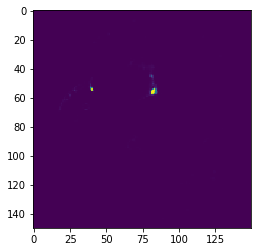

In [92]:
confidence_pos_o = confidence_pos_o.reshape([150,150])
plt.imshow(confidence_pos_o)

In [42]:
confidence_pos = np.array([])
confidence_pos = np.append(confidence_pos, confidences[:,0].cpu().numpy())

In [47]:
confidence_pos = np.append(confidence_pos, confidences[:,0].cpu().numpy())
confidence_pos.shape

(1005,)

In [48]:
confidence_pos.reshape([5,201])

array([[0.00047639, 0.00040763, 0.00036647, ..., 0.00041625, 0.00041842,
        0.00043007],
       [0.00042846, 0.00041612, 0.00042211, ..., 0.00043208, 0.00042155,
        0.00041038],
       [0.00039553, 0.00038518, 0.00037936, ..., 0.00042468, 0.00042661,
        0.0004228 ],
       [0.00042986, 0.00044521, 0.00049876, ..., 0.00097901, 0.00101091,
        0.00098712],
       [0.00093081, 0.00088574, 0.00088503, ..., 0.00026629, 0.00026412,
        0.00025841]])

In [45]:
def sliding_window(image, stepSize, windowSize, xmin, xmax, ymin, ymax):
    print(xmin,xmax,ymin,ymax)
    for x in range(xmin, xmax, stepSize):
        for y in range(ymin, ymax, stepSize):
            yield (x, y, image.crop(box=(x - windowSize/2,y - windowSize/2, x + windowSize/2, y + windowSize/2)))

In [72]:
def convolution(image, stepSize):
    coord_list = np.empty((0,2), int)
    for y in range(0, image.size[1], stepSize):
        for x in range(0, image.size[0], stepSize):
            coord_list = np.append(coord_list, [[x,y]], axis=0)
    return coord_list

In [73]:
img = Image.open('/home/rliu/yolo2/v2_pytorch_yolo2/data/an_data/VOCdevkit/VOC2007/JPEGImages/006501.jpg').convert('L')
img = torchvision.transforms.functional.resize(img, (300,300), interpolation=2)
coord_list = convolution(img, 2)

In [74]:
coord_list.shape

(22500, 2)

In [75]:
output_path = '/home/rliu/coord_list.npy'
np.save(output_path, coord_list)

In [76]:
np.load(output_path)

array([[  0,   0],
       [  2,   0],
       [  4,   0],
       ...,
       [294, 298],
       [296, 298],
       [298, 298]])

In [77]:
x,y=coord_list[100]

In [78]:
coord_list.shape[0]

22500

In [80]:
coord_list[150]

array([0, 2])

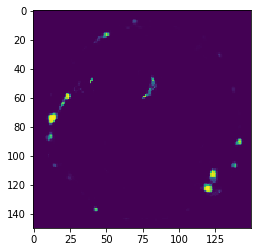

In [2]:
plt.imshow(np.load('/home/rliu/defect_classifier/convolution_test/neg/006501.npy'))